In [7]:
import os
import pandas 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def res_file_to_df(file):
    '''
    Converts a res file into a pandas DataFrame for a single day
    '''
    # header information
    columns = ['MJD', 
               'frac of a day', 
               'GPS range AB [m]', 
               'GPS range rate AB [m/s]', 
               'Kband range [m]',
               'Kband range rate [m/s]',
               'O-C range rate [m/s]',
               'Latitude [deg]',
               'Longitude [deg]',
               'Arg. of lat. [deg]',
               'beta [deg]']
    # collect data
    data_array = [] # empty container 
    with open(path) as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if i < 12: continue # skip header information
            line_entries = line.split(' ') # split lines with space delimiter
            line_entries = np.array(line_entries) # convert to numpy array
            line_entries = np.delete(line_entries, np.argwhere(line_entries=='')).astype(float) # convert to floats
            data_array.append(line_entries) # collect vectors
    data_array = np.vstack(data_array) # stack vectors into an array 
    df = pandas.DataFrame(data=data_array,columns=columns) # convert stack to pandas DataFrame
    return df

## Plan
Setup for the MINE-network  
Use the post fit residuals (7th column O-C range rate [m/s]) as one random variable  
The other random variable is a vector of what remains. This vector gives the position of the satellite over earth with some redundant infomation, like different coordinates and time stamps.  
For the upper channel we feed in vectors and residuals as they appear in the tables  
For the lower channel we shuffle the residuals  
The network will then try and distinguish between residuals tied to actual positions and those that are random   
If the network can distinguish then the position is important, i.e., some signal has been consumed into the residuals

In [3]:
# create datasets by concatenating data across all days from all 12 months
X = None
y = None
root_path  = '/Users/brandonlpanos/Desktop/grace/datasets/'
for month in os.listdir(root_path):    
    for day in os.listdir(root_path + month):
        path = root_path + month + '/' + day
        
        try: df = res_file_to_df(path) # convert res file into pandas DataFrame
        except: continue # some datasets are empty, if any problems just skip
            
        y_day = np.array(df['O-C range rate [m/s]']) # target random variable residuals 
        df2 = df.copy()
        df2 = df2.drop(['O-C range rate [m/s]'], axis=1) # drop target variable from df
        X_day = df2.to_numpy() # construct matrix out of remaining columns
        
        # concatenate x matrices
        try: X = np.concatenate( (X, X_day), axis=0 )
        except: X = X_day
        
        # concatenate y vectors 
        try: y = np.concatenate( (y, y_day) )
        except: y = y_day
print(X.shape, y.shape)

(5981627, 10) (5981627,)


In [4]:
# np.savez('/Users/brandonlpanos/Desktop/grace/data', X=X, y=y)

In [5]:
fhand = np.load('/Users/brandonlpanos/Desktop/grace/data.npz')
X = fhand['X']
y = fhand['y']
print(X.shape, y.shape)

(5981627, 10) (5981627,)


## MINE-network 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [ ]:
# data loader that generates samples of joints and marginals 
class MINEDataLoader(torch.utils.data.Dataset):
    def __init__(self, line1='MgII', line2='CII', num_samples=1000):
        self.num_samples = num_samples
        data1 = np.load('/Users/brandonlpanos/Desktop/grace/data.npz')['X']
        data2 = np.load('/Users/brandonlpanos/Desktop/grace/data.npz')['y']
        data1, data2 = transform2(data1, data2, num_samples)
        self.nprof1, self.nprof2 = transform3(data1, data2)
        
    def __len__(self):
        return (self.num_samples * 2)
    
    def __getitem__(self, indx):
        x_sample = torch.from_numpy(self.nprof1).type(torch.FloatTensor)
        y_sample = torch.from_numpy(self.nprof2).type(torch.FloatTensor)
        y_shuffle = torch.from_numpy(np.random.permutation(y_sample)).type(torch.FloatTensor)
        return x_sample, y_sample, y_shuffle

In [142]:
# data loader that generates samples of joints and marginals 
class MINEDataLoader(torch.utils.data.Dataset):
    def __init__(self, path_to_data, n_samples):
        self.n_samples = n_samples
        self.data1 = torch.from_numpy(np.load(path_to_data)['X']).type(torch.FloatTensor)
        self.data2  = torch.from_numpy(np.load(path_to_data)['y']).type(torch.FloatTensor)

    def __len__(self):
        return len(self.data2)

    def __getitem__(self, indx):
        rand_index = np.random.randint(0, len(self.data1)-1, self.n_samples)
        x_sample = self.data1[rand_index]
        y_sample = self.data2[rand_index]
        y_shuffle = self.data2[np.random.randint(0, len(self.data2)-1, len(y_sample))]
        return x_sample, y_sample, y_shuffle

In [155]:
path_to_data = '/Users/brandonlpanos/Desktop/grace/data.npz'
dataloader = torch.utils.data.DataLoader(MINEDataLoader(path_to_data, 1000))

torch.Size([1, 1000, 10]) torch.Size([1, 1000]) torch.Size([1, 1000])


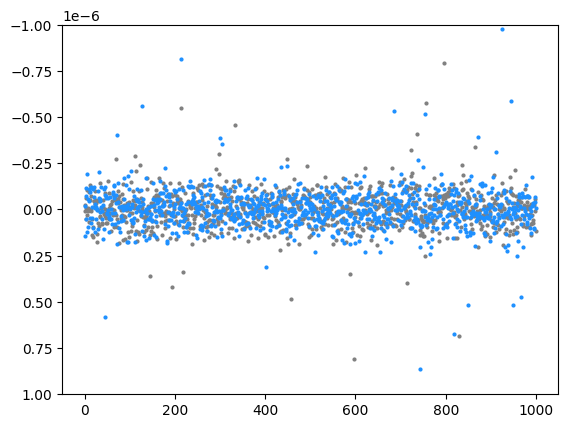

In [210]:
X, y, yy = next(iter(dataloader))
print(X.shape, y.shape, yy.shape)
plt.scatter(range(len(y[0])),y[0], c='grey', s=4)
plt.scatter(range(len(yy[0])),yy[0], c='dodgerblue', s=4)
plt.ylim(1e-6,-1e-6)
plt.show()

In [214]:
# Define Mine-network using PyTorch
class MINEnetwork(nn.Module):
    def __init__(self, d1, dz):
        super(MINEnetwork, self).__init__()
        self.fc1 = nn.Linear(d1, dz)
        self.fc2 = nn.Linear(dz + 1, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x, y):
        x = self.fc1(x)
        x = F.relu(x)
        out = torch.cat((x, y))
        out = self.fc2(out) 
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [213]:
X, y, yy = next(iter(dataloader))
print(X.shape, y.shape)

torch.Size([1, 1000, 10]) torch.Size([1, 1000])


In [228]:
d1 = 10
dz = 3
fc1 = nn.Linear(d1, dz)
out = fc1(X)
print(out.shape)
out = torch.cat((out, torch.Tensor(5).type(torch.FloatTensor)))
fc2 = nn.Linear(dz + 1, 2)
out = fc2(out)
print(out.shape)


torch.Size([1, 1000, 3])


RuntimeError: Tensors must have same number of dimensions: got 3 and 1

In [ ]:
# Define the network in the figure using PyTorch
class MIEstimator1(nn.Module):
    def __init__(self, d1, d2, d_z):
        super(MIEstimator1, self).__init__()
        self.fc1 = nn.Linear(d1, d_z)
        self.fc2 = nn.Linear(d2, d_z)
        self.fc3 = nn.Linear(2*d_z, d_z)
        self.fc4 = nn.Linear(d_z, 1)

    def forward(self, x, y):
        x = self.fc1(x)
        y = self.fc2(y)
        out = torch.cat((x, y), 2)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)        
        return out
